In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [79]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [80]:
train_df_path ='../07. Pemodelan Data (Data Mining)/dataset/Final_Dataset.csv'


In [81]:
train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[0,1], skiprows=1)

train_df.columns = ['full_text', 'emotion']

In [82]:
train_df.head(10)

,full_text,emotion
0,"['pengabdian', 'terpuji', 'meskipun', 'terliha...",Neutral
1,"['baru', 'mengirim', 'foto']",Neutral
2,"['apa', 'kabar', 'dunia', 'twitter', 'masihkah...",Neutral
3,"['yah', 'gimana', 'sih', 'yaudah', 'susul', 's...",Neutral
4,"['ka', 'dorg', 'suro', 'beli', 'medium', 'set']",Neutral
5,"['ayo', 'cek', 'koleksinya', 'temukan', 'angry...",Neutral
6,"['kalau', 'biasa', 'biasa', 'sudah']",Neutral
7,"['tiap', 'tiap', 'twit', 'tak', 'selalu', 'per...",Neutral
8,"['halo', 'v', 'apa', 'kabar', 'nih']",Neutral
9,"['pagi', 'ruby', 'apa', 'kabar']",Neutral


In [83]:
def get_label_idx(label):
    if label == 'Fear':
        return 5
    elif label == 'Sad':
        return 4
    elif label == 'Love':
        return 3
    elif label == 'Joy':
        return 2
    elif label == 'Anger':
        return 1
    elif label == 'Neutral':
        return 0


train_df['emotion'] = train_df['emotion'].apply(get_label_idx)


In [84]:
#hapus label selain 0-5
train_df = train_df[train_df['emotion'] <= 5]


In [85]:
train_df

,full_text,emotion
0,"['pengabdian', 'terpuji', 'meskipun', 'terliha...",0.0
1,"['baru', 'mengirim', 'foto']",0.0
2,"['apa', 'kabar', 'dunia', 'twitter', 'masihkah...",0.0
3,"['yah', 'gimana', 'sih', 'yaudah', 'susul', 's...",0.0
4,"['ka', 'dorg', 'suro', 'beli', 'medium', 'set']",0.0
...,...,...
57295,"['cod', 'beli', 'euphoria', 'wonderland', 'la'...",2.0
57296,"['ลองด', 'cod', 'flash', 'sale', 'ก', 'โล', 'แ...",2.0
57297,"['wal', 'cod', 'an', 'shopee', 'kawa', 'pakai'...",0.0
57298,"['temukan', 'bisa', 'cod', 'light', 'stick', '...",0.0


In [86]:
# Define the function to join the list of tokens as a single document string
def join_text_list(texts):
    try:
        texts = ast.literal_eval(texts)
        return ' '.join([text for text in texts])
    except (ValueError, SyntaxError):
        return None  # or return an empty string if you prefer

# Apply the function to the 'full_text' column
train_df["full_text"] = train_df["full_text"].apply(join_text_list)

# Display the first few rows of the preprocessed column
train_df

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,0.0
1,baru mengirim foto,0.0
2,apa kabar dunia twitter masihkah selucu seabsu...,0.0
3,yah gimana sih yaudah susul sebelumnya sarapan...,0.0
4,ka dorg suro beli medium set,0.0
...,...,...
57295,cod beli euphoria wonderland la foret fairy ha...,2.0
57296,ลองด cod flash sale ก โล แมคคายกกระสอบ ต กก ต ...,2.0
57297,wal cod an shopee kawa pakai qris lah yuu,0.0
57298,temukan bisa cod light stick treasure bluetoot...,0.0


In [87]:
jumlah_netral = len(train_df[train_df['emotion'] == 0])
jumlah_marah = len(train_df[train_df['emotion'] == 1])
jumlah_senang = len(train_df[train_df['emotion'] == 2])
jumlah_cinta = len(train_df[train_df['emotion'] == 3])
jumlah_sedih = len(train_df[train_df['emotion'] == 4])
jumlah_takut = len(train_df[train_df['emotion'] == 5])

print("Jumlah Netral: ", jumlah_netral)
print("Jumlah Marah: ", jumlah_marah)
print("Jumlah Senang: ", jumlah_senang)
print("Jumlah Cinta: ", jumlah_cinta)
print("Jumlah Sedih: ", jumlah_sedih)
print("Jumlah Takut: ", jumlah_takut)

Jumlah Netral:  12981
Jumlah Marah:  11069
Jumlah Senang:  12307
Jumlah Cinta:  5389
Jumlah Sedih:  7272
Jumlah Takut:  7996


In [88]:
# Split dataset menjadi fitur (X) dan label (y)
X_train = train_df['full_text']
y_train = train_df['emotion']


In [89]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [90]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((51312,), (5702,), (51312,), (5702,))

## Generate Padded Sequence

In [91]:
# Parameters

vocab_size = 60000 
max_length = 64 
embedding_dim = 8 
trunc_type='post' 
oov_tok = "<OOV>" 

In [92]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Define the "all_texts" variable
X_train = [str(text) for text in X_train]
X_valid = [str(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [93]:
X_train

['hentikan penjajahan ilegal israel harus menolak pengusiran rakyat palestina rakyat palestina berhak mendapatkan hak perlakuan sama indonesia berdiri bersama rakyat palestina',
 'kalau anak dijadikan bahan politik belasah mantan menteri pendidikan prestasi jatuh teruk masa menteri kena amik kira bahawa pendidikan terjejas semasa covid melanda in any case radzi gagal menangani impak pandemik efektif',
 'admin facebook mau tanya iya membagikan kiriman halaman grup tiba akun tidak bukak dan bilang sesi hilang bisa iya membagikan kiriman halaman ke grup tidak diperbolehkan mohon di balas iya admin bantu saya iya admin facebook',
 'iringing do a semoga anies cak imin menjadi pres wakil pres ri diridhoi allah swt amin iya rabbalalamiin',
 'mesti la bwak makan sembng n makan sekali kenyang baru senang anak shopping',
 'kenangan sma tiap pulang sekolah pulang minta uang teman cewek masing seribu bilangnya buat bensin malah nyasar warung nongki beli udud hahahahah',
 'where is israel and iran 

In [94]:
y_train

38147    5.0
35537    1.0
28062    5.0
30263    3.0
5747     2.0
        ... 
54604    5.0
38299    3.0
860      0.0
15795    4.0
56707    0.0
Name: emotion, Length: 51312, dtype: float64

### kamus data untuk api Training

In [95]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [96]:
print(train_padded[0])

[ 3147  2262  3838    10   213  1188 12983    65    19    65    19  1935
   703   503  6033     6    20  1682   116    65    19     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


## Word Embedding

In [97]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=1, workers=4)

In [98]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [99]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.98060465, -1.44568503, -1.5240798 , ..., -2.19835138,
         2.60638261,  0.47763714],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [100]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

('rahajeng', array([ 2.68627429, -1.46095383,  2.73632741, -1.00166917,  2.73253679,
       -3.6165154 ,  6.65036011, -1.72403669]))


## Build and Compile Model

In [101]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    # tf.keras.layers.Embedding(vocab_size, 8, input_shape=(max_length,)),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    # tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\TEMP\miniconda3\envs\skripsi\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 64, 8)          │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 128)        │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,902 (2.10 MB)

 Trainable params: 70,902 (276.96 KB)

 Non-trainable params: 480,000 (1.83 MB)

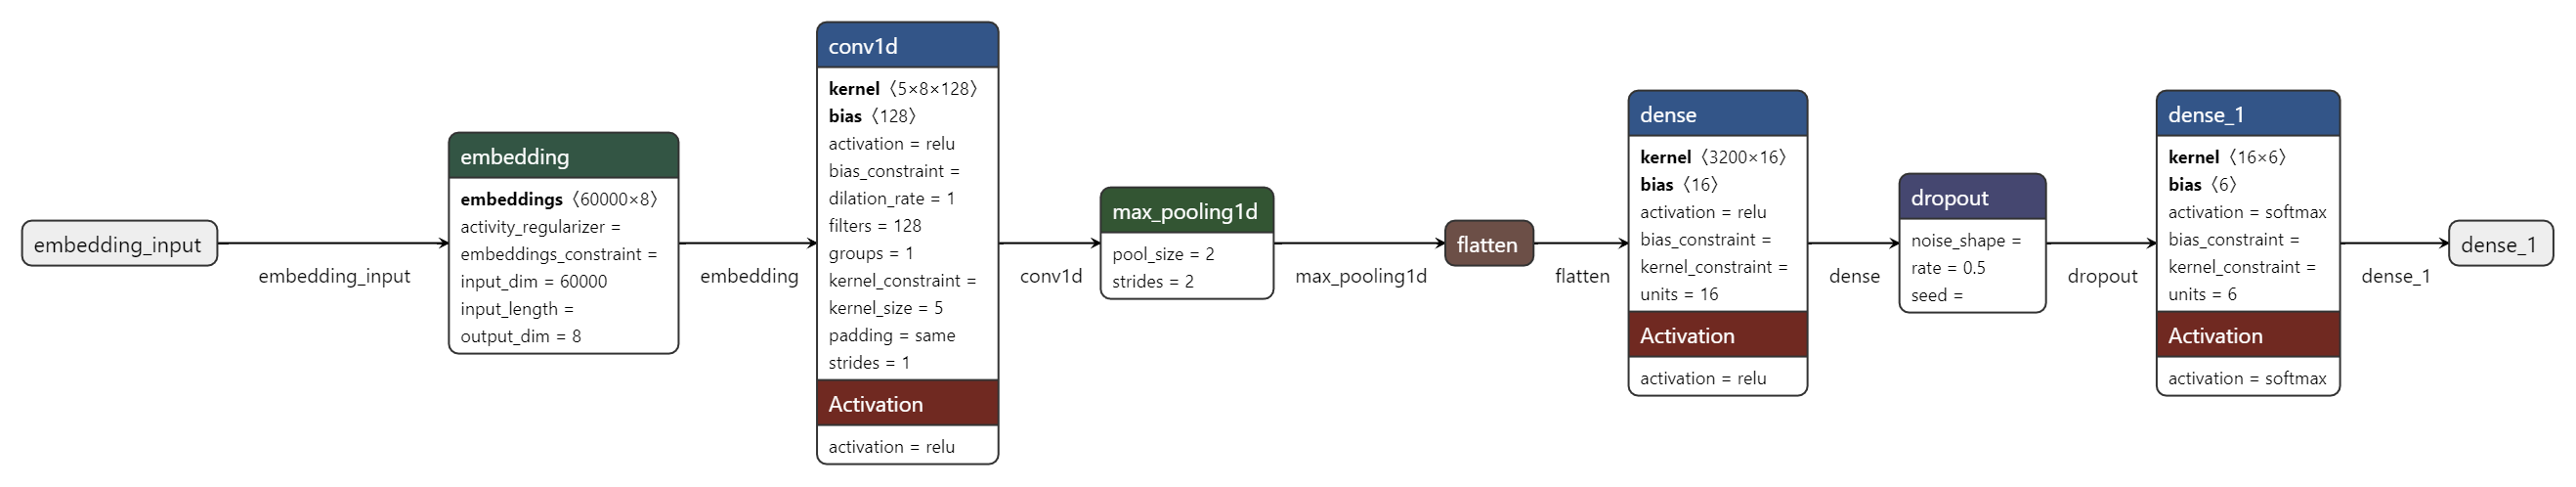

In [102]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_3
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-2.9806046  -1.445685   -1.5240798  ... -2.1983514   2.6063826
   0.47763714]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: conv1d_3
Weights Shape (Tensor 0): (5, 8, 128)
Weights (Tensor 0):
[[[ 3.5723597e-02 -5.4175403e-02  7.1365625e-02 ... -6.3503474e-02
    7.4463010e-02  3.8975880e-02]
  [-6.3420370e-02  4.4846386e-03  7.1309134e-03 ...  4.4863343e-02
   -6.1773017e-02 -5.2252434e-02]
  [ 8.9221865e-02  2.5510788e-05 -6.4797893e-02 ... -6.8273395e-03
    1.9218653e-02  5.7919458e-02]
  ...
  [-8.5013837e-02 -2.2434071e-02  5.1726669e-02 ...  8.5466862e-02
    5.0809696

## Train Model

In [103]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128, 
    epochs=num_epochs, 
    validation_data=(valid_padded, y_valid), 
)

Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2858 - loss: 1.6930 - val_accuracy: 0.3853 - val_loss: 1.5340
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3209 - loss: 1.5962 - val_accuracy: 0.4035 - val_loss: 1.4828
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3517 - loss: 1.5474 - val_accuracy: 0.4130 - val_loss: 1.4335
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3778 - loss: 1.5048 - val_accuracy: 0.4407 - val_loss: 1.4072
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3970 - loss: 1.4713 - val_accuracy: 0.4311 - val_loss: 1.4087
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4089 - loss: 1.4555 - val_accuracy: 0.4523 - val_loss: 1.3812
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4143 - loss: 1.4328 - val_accuracy: 0.4523 - val_loss: 1.3861
Epoch 8/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4194 - loss: 1.4259 - val_a

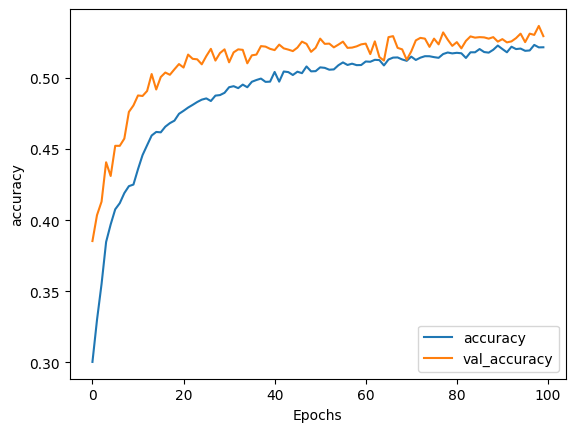

In [104]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

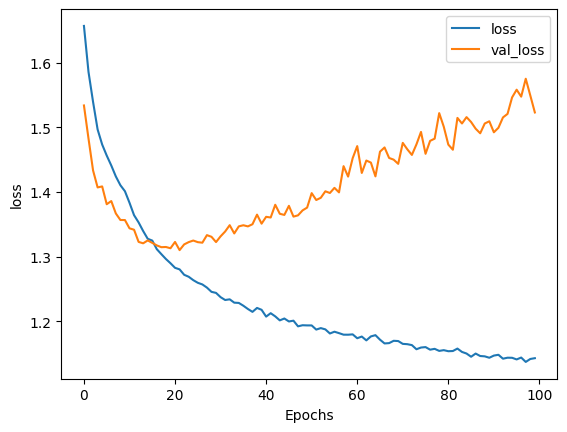

In [105]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [106]:
#sklearn report
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_valid, y_pred))

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5262 - loss: 1.5012
Loss:  1.5231903791427612
Accuracy:  0.5294633507728577
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.62      0.45      0.53      1333
         1.0       0.40      0.75      0.52      1028
         2.0       0.58      0.71      0.64      1249
         3.0       0.75      0.33      0.46       569
         4.0       0.55      0.42      0.48       709
         5.0       0.58      0.34      0.43       814

    accuracy                           0.53      5702
   macro avg       0.58      0.50      0.51      5702
weighted avg       0.57      0.53      0.52      5702



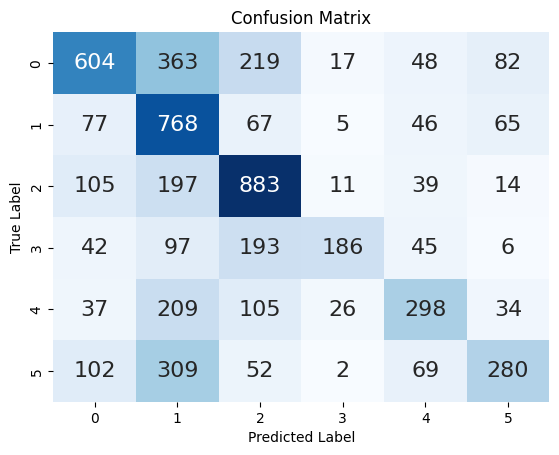

In [107]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [108]:
print(cm)

[[604 363 219  17  48  82]
 [ 77 768  67   5  46  65]
 [105 197 883  11  39  14]
 [ 42  97 193 186  45   6]
 [ 37 209 105  26 298  34]
 [102 309  52   2  69 280]]


In [109]:
#predict another data input from the model
def predict_emotion(text):
    # Tokenisasi
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi
    pred = model.predict(padded)

    print("Prediksi:", pred)
    pred = np.argmax(pred, axis=1)
    

    # Mengembalikan label emosi
    if pred == 0:
        return "Neutral"
    elif pred == 1:
        return "Anger"
    elif pred == 2:
        return "Joy"
    elif pred == 3:
        return "Love"
    elif pred == 4:
        return "Sad"
    elif pred == 5:
        return "Fear"

#make 10 senteces twitter in predict emotion
predict_emotion("saya sangat senang hari ini")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediksi: [[3.1327474e-01 1.0451577e-03 4.5909536e-01 2.1492282e-01 1.1385036e-02
  2.7682263e-04]]


'Joy'

In [110]:
#save model
model.save('./model/model-cnn.h5')